In [1]:
import torch 
import torch.nn as nn 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
import os 
from torchvision.io import read_image
import argparse
import os
import random
import torch.nn.parallel
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.datasets import ImageFolder

In [2]:
# Root directory for dataset
root_dir = r'/run/media/magnusjsc/T7/Classification-and-3D-reconstruction-of-archaeological-artifacts_DATA/Splitted data by era - GAN project/test_iron'

# Number of workers for dataloader. (4 * nr_gpus)
workers = (4 * 1)

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Number of feature maps in generator
ngf = 56

# Number of feature maps in discriminator
ndf = 56

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("Device: ", device)

Device:  cuda:0


In [3]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize images to 64x64
    transforms.ToTensor(),           # Convert images to PyTorch tensors
])

dataset = ImageFolder(root=root_dir, transform=transform)

data_loader = DataLoader(dataset, batch_size, shuffle = True)

for images, labels in data_loader:
    print(images.shape)  # Print the shape of the images batch
    print(labels)  # Print the labels for the images
    break  # Only print the first batch for demonstration


class_to_idx = dataset.class_to_idx

# Print the mapping of class names to labels
print(class_to_idx)


torch.Size([128, 3, 64, 64])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
{'iron': 0}


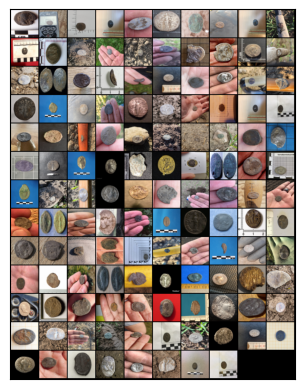

In [4]:
def show_image_grid(images: torch.Tensor, ncol: int): 
    image_grid = make_grid(
        images, 
        ncol
    ) # Make images into a grid 

    image_grid = image_grid.permute(1, 2, 0) # Move channel to the last 
    image_grid = image_grid.cpu().numpy() 

    plt.imshow(image_grid)
    plt.xticks([]) # Empty x and y labels 
    plt.yticks([])
    plt.show() 


show_image_grid(
    images = images, 
    ncol = 10
)

In [5]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)
    
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)


# Discriminator Code
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 448, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(448, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(448, 224, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(224, 112, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(112, 56, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(56, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [6]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

if (device.type == 'cuda') and (ngpu > 1):
    optimizerD = nn.DataParallel(optimizerD, list(range(ngpu)))
    optimizerG = nn.DataParallel(optimizerG, list(range(ngpu)))

In [40]:
n_channels = 3 

def create_models(hyperparameters): 
    d_model = d(hyperparameters)
    g_model = g(hyperparameters)
    opt_g = Adam(g_model.parameters(), lr = hyperparameters['continuous']['learning_rate'][0])  
    opt_d = Adam(d_model.parameters(), lr = hyperparameters['continuous']['learning_rate'][0])
    criterion = nn.BCEWithLogitsLoss() 
    return g_model, d_model, opt_g, opt_d, criterion
    

class d(nn.Module): # Discriminator
    def __init__(
        self,
        hyperparameters: dict 
    ): 
        super(d, self).__init__()
        self.num_layers = hyperparameters['discrete']['num_layers'][3]  # HANDLE OUT OF BOUNDS WHEN i = 3 
        self.layers = nn.ModuleList() 
        final_channel = 0 
        final_kernel = 0 
        final_padding = 0
        final_stride = 0
        # FOR LOOP WITH ADDING LAYERS 
        for i in range(self.num_layers):
            in_channels = n_channels if i == 0 else hyperparameters['discrete']['out_channels'][0][i - 1]
            out_channels = hyperparameters['discrete']['out_channels'][0][i]
            kernel_size = hyperparameters['discrete']['kernel_size'][0][i]
            
            
        # Calc FC Layer size 
        # FC layer

    def forward(self, x):
        # TODO: FINISH
        return x 

class g(nn.Module): # Generator
    def __init__(
        self,
        hyperparameters: dict 
    ): 
        super(g, self).__init__()
        self.num_layers = hyperparameters['discrete']['num_layers'][0]
        self.layers = nn.ModuleList() 
        final_channel = 0 
        final_kernel = 0 
        final_padding = 0
        final_stride = 0
        # FOR LOOP WITH ADDING LAYERS 
        for i in range(self.num_layers):
            print("MORE LAYERS!")
        # Calc FC Layer size 
        # FC layer
        print("Do SOMETHING!")

    def forward(self, x):
        # TODO: FINISH
        return x 

# TODO: 
# SUMMARY FOR BOTH MODELS 

In [41]:
# Bayesian Optimization Part:
import torch
from botorch.models import SingleTaskGP
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood

def objective_function(X):
    print(X)
    num_layers = X[4]
    # Create the models based on chosen hyperparameters (create_models()) <- look above cell

    # Train the models 

    # Calulcate losses and add these together

    # Return for candidate loss
    
    
hyperparams = {
    'continuous': {
        'learning_rate': (0.001, 0.1),
        'dropout_rate': (0.0, 1.0),
        'num_epochs': (16, 128),
        'batch_size': (10, 100)
    },
    'discrete': {
        'num_layers': [1, 2, 3, 4],
        'out_channels': [[16, 32, 64], [32, 64, 128], [64, 128, 256]],
        'kernel_size': [[3, 3, 3], [3, 5, 7], [2, 3, 4]],
        'padding': [[0, 1, 2], [1, 2, 3], [0, 0, 1], [0, 0, 0]],
        'stride': [[1, 1, 1], [2, 2, 2], [3, 3, 3]],
        'batch_size': [16, 32, 64, 128, 256],
        'image_size': [32, 64, 128, 224],
        'latent_vector': [50, 100, 200],
        'num_feature_maps': [50, 100, 150]
    }
}

bounds_continuous = [hyperparams['continuous'][param] for param in hyperparams['continuous']]
bounds_discrete = [hyperparams['discrete'][param] for param in hyperparams['discrete']]

# hyperparams_discrete_values = [val for sublist in bounds_discrete for val in sublist]
# bounds = bounds_continuous + hyperparams_discrete_values
bounds = bounds_continuous + bounds_discrete

# Test
objective_function(bounds)
create_models(hyperparameters = hyperparams)

init_samples = 10
num_restarts = 10
raw_samples = 10 

best_loss = float('inf')
best_params = None 

for _ in range(num_restarts):
    X = torch.rand(init_samples, len(bounds), device = device)
    Y = objective_function(X)

    model = SingleTaskGP(X, Y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)

    EI = ExpectedImprovement(model, best_f = best_loss)

    candidate, _ = optimize_acqf(
        EI, bounds = torch.tensor(bounds, device = device),
        q = 1, num_restarts = num_restarts, raw_samples = raw_samples
    )

    candiate_loss = objective_function(candidate)

    if candiate_loss < best_loss:
        best_loss = candiate_loss
        best_params = candidate


[(0.001, 0.1), (0.0, 1.0), (16, 128), (10, 100), [1, 2, 3, 4], [[16, 32, 64], [32, 64, 128], [64, 128, 256]], [[3, 3, 3], [3, 5, 7], [2, 3, 4]], [[0, 1, 2], [1, 2, 3], [0, 0, 1], [0, 0, 0]], [[1, 1, 1], [2, 2, 2], [3, 3, 3]], [16, 32, 64, 128, 256], [32, 64, 128, 224], [50, 100, 200], [50, 100, 150]]


IndexError: list index out of range

In [ ]:
# Train the GAN with the best hyperparameters 
def train():
    print("TRAINING and GAINING!")